In [16]:
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV

In [17]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
%matplotlib inline
data = pd.read_csv('train.csv'  , sep=',')
data = data.drop(['PassengerId','Name','Ticket','Fare','Cabin','Embarked'], axis='columns') # первый аргумент - список ненужных признаков,
                                                   # второй - поиск имен признаков по названиям колонок, а не строк
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 41.9+ KB


In [18]:
data['Sex']=np.where(data['Sex']=='male',1,data['Sex'])
data['Sex']=np.where(data['Sex']=='female',0,data['Sex'])
data['Sex']=data['Sex'].astype(np.int64)

data['Age']=data['Age'].fillna(data['Age'].median())
data['Age']=data['Age'].round(0)
data['Age']=data['Age'].astype(np.int64)

data['Member_Family']=data['Parch']+data['SibSp']
data['Member_Family']=np.where(data['Member_Family']>0,1,0)
data = data.drop(['Parch','SibSp'], axis='columns')
data.dtypes

Survived         int64
Pclass           int64
Sex              int64
Age              int64
Member_Family    int32
dtype: object

In [19]:
data.head(5)

,Survived,Pclass,Sex,Age,Member_Family
0,0,3,1,22,1
1,1,1,0,38,1
2,1,3,0,26,0
3,1,1,0,35,1
4,0,3,1,35,0


In [20]:
X = data[data.columns[:-1]]
y = data['Survived']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

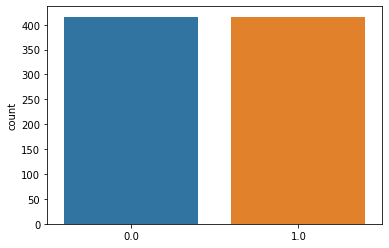

In [6]:
X_train.reset_index(inplace=True,drop=True)
y_train.reset_index(drop=True, inplace=True)

dead=X_train[y_train == 0]
isdead=dead[0:len(X_train[y_train == 0])-len(X_train[y_train == 1])]
X_train_start = pd.concat([X_train,isdead],ignore_index = True)
y_train_strat = pd.concat([y_train,pd.Series(np.ones(X_train_start.shape[0]-X_train.shape[0]))],
                          ignore_index=True)
                          
sns.countplot(y_train_strat)

In [21]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
#Нормализация
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_start), columns=X_train_start.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_train_start.columns)
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)


In [22]:
col = ['coef_%s'%i for i in  list(X_train_scaled.columns.values) ]
ind = ['C=%f'%i for i in [10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4, 10**5]]
coef_matrix_simple = pd.DataFrame(index=ind, columns=col)

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve, roc_auc_score, f1_score, fbeta_score, auc

In [24]:
accuracy = []
C_list = [10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4, 10**5]

for i in range(0, len(C_list)):
    clf = LogisticRegression(C=C_list[i], random_state=10, solver='lbfgs', max_iter=200)
    clf.fit(X_train_scaled, y_train)
    a=clf.predict(X_test_scaled)
    current_score = recall_score(y_test, a)
    coef_matrix_simple.iloc[i,:]=clf.coef_
    accuracy.append(current_score)
    print('При С =', C_list[i], 'точность равна', current_score)
max_score = 0    
for i in range(0, len(accuracy)):
    if max_score < accuracy[i]:
        max_score = accuracy[i]
        C_for_max_score = i
print('\n')
print('Максимальная точность (score), равная', max_score,', получается при С, равном', C_list[C_for_max_score])
pd.options.display.float_format = '{:,.3g}'.format
coef_matrix_simple

При С = 1e-05 точность равна 0.0
При С = 0.0001 точность равна 0.0
При С = 0.001 точность равна 0.0
При С = 0.01 точность равна 0.9156626506024096
При С = 0.1 точность равна 1.0
При С = 1 точность равна 1.0
При С = 10 точность равна 1.0
При С = 100 точность равна 1.0
При С = 1000 точность равна 1.0
При С = 10000 точность равна 1.0
При С = 100000 точность равна 1.0


Максимальная точность (score), равная 1.0 , получается при С, равном 0.1


,coef_Survived,coef_Pclass,coef_Sex,coef_Age
C=0.000010,0.00158,-0.0004,-0.000829,-5.08e-05
C=0.000100,0.0158,-0.00397,-0.00823,-0.000507
C=0.001000,0.151,-0.0372,-0.077,-0.00492
C=0.010000,1.08,-0.225,-0.453,-0.0389
C=0.100000,3.67,-0.475,-0.852,-0.151
C=1.000000,7.15,-0.595,-0.975,-0.284
C=10.000000,10.9,-0.67,-1.04,-0.399
C=100.000000,14.9,-0.724,-1.09,-0.496
C=1000.000000,19,-0.763,-1.11,-0.576
C=10000.000000,23.2,-0.697,-1.07,-0.823


In [26]:
clf = LogisticRegression(C=C_list[C_for_max_score], random_state=10,max_iter=200,solver='lbfgs')
#clf.fit(X_train_scaled, y_train_strat)
clf.fit(X_train_scaled, y_train)
a=clf.predict(X_test_scaled)
print('Accuracy:', accuracy_score(y_test, a))
print('Precision:', precision_score(y_test, a))
print('Recall:', recall_score(y_test, a))
print('ROC AUC:', roc_auc_score(y_test, a))
pr, rec, _ = precision_recall_curve(y_test, a)
print('PRC AUC:', auc(rec, pr))
print('F1:', f1_score(y_test, a))
print('F0.5:', fbeta_score(y_test, a, 0.5))
print('F2:', fbeta_score(y_test, a, 2))

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
ROC AUC: 1.0
PRC AUC: 1.0
F1: 1.0
F0.5: 1.0
F2: 1.0


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass beta=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass beta=2 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [27]:
 accuracy = []
C_list = [10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4, 10**5]

for i in range(0, len(C_list)):
    clf = LogisticRegression(C=C_list[i], random_state=10, penalty='l1',solver='liblinear', max_iter=200)
    clf.fit(X_train_scaled, y_train)
    a=clf.predict(X_test_scaled)
    #pr, rec, _ = precision_recall_curve(y_test, a)
    current_score = recall_score(y_test, a)
    coef_matrix_simple.iloc[i,:]=clf.coef_
    accuracy.append(current_score)
    print('При С =', C_list[i], 'точность равна', current_score)
max_score = 0    
for i in range(0, len(accuracy)):
    if max_score < accuracy[i]:
        max_score = accuracy[i]
        C_for_max_score = i
print('\n')
print('Максимальная точность (score), равная', max_score,', получается при С, равном', C_list[C_for_max_score])
coef_matrix_simple

При С = 1e-05 точность равна 0.0
При С = 0.0001 точность равна 0.0
При С = 0.001 точность равна 0.0
При С = 0.01 точность равна 1.0
При С = 0.1 точность равна 1.0
При С = 1 точность равна 1.0
При С = 10 точность равна 1.0
При С = 100 точность равна 1.0
При С = 1000 точность равна 1.0
При С = 10000 точность равна 1.0
При С = 100000 точность равна 1.0


Максимальная точность (score), равная 1.0 , получается при С, равном 0.01


,coef_Survived,coef_Pclass,coef_Sex,coef_Age
C=0.000010,0,0,0,0
C=0.000100,0,0,0,0
C=0.001000,0,0,0,0
C=0.010000,0.599,0,-0.41,0
C=0.100000,5.88,-0.0775,-0.695,0
C=1.000000,10.6,-0.0945,-0.676,0
C=10.000000,15.1,-0.262,-0.758,0
C=100.000000,19.5,-1.78,-1.86,-1.03
C=1000.000000,22.8,-3.51,-2.42,-5.96
C=10000.000000,23.6,-3.82,-2.58,-6.69
